<a href="https://colab.research.google.com/github/fearlix/drl/blob/main/DSTI3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Deep Learning Model for Image Classification for planes**

## **1. Imports & Setup**

In [20]:
!pip install datasets torchvision torch

In [21]:
from datasets import load_dataset, concatenate_datasets, DatasetDict
from huggingface_hub import (
    HfApi, login, whoami, create_repo, upload_file,
    list_repo_files, hf_hub_download
)

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR

import torchvision.models as models
from torchvision import transforms
from PIL import Image

import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    confusion_matrix, classification_report, precision_score,
    recall_score, f1_score, roc_auc_score
)

from google.colab import userdata, files

import random
import time
from tqdm import tqdm

## **2. Data Loading & Labeling**

This function loads two datasets from Hugging Face: one for planes and one for cars. It prints both datasets to check if they were loaded correctly and then returns them for further use.

In [22]:
def load_datasets():
    """Loads the datasets from Hugging Face."""
    planes_dataset = load_dataset("fearlixg/planes_splitted")
    cars_dataset = load_dataset("fearlixg/cars_splitted")
    return planes_dataset, cars_dataset

This function adds labels to the datasets: **1 for planes** and **0 for cars**. It does this by applying a small helper function that adds a label field to each example. Then, it updates both the training and test sets of each dataset with the correct labels. Finally, it returns the updated datasets.

In [23]:
def label_datasets(planes_dataset, cars_dataset):
    """Assigns labels: Planes (1), Cars (0)."""
    def add_label(example, label):
        example["label"] = label
        return example

    for dataset in [planes_dataset, cars_dataset]:
        label = 1 if dataset == planes_dataset else 0
        dataset["train"] = dataset["train"].map(lambda x: add_label(x, label))
        dataset["test"] = dataset["test"].map(lambda x: add_label(x, label))

    return planes_dataset, cars_dataset

## **3. Merge & Balance the Dataset**

This function merges two datasets, one for planes and one for cars, and balances them by oversampling the smaller class. It first extracts the training and test sets from both datasets and checks the number of samples in each class. If one class has fewer samples, it generates additional images using data augmentation techniques such as random cropping, flipping, rotation, and color adjustments. The function then combines the original and augmented samples to create a balanced training set while merging the test sets without any modifications.

In [24]:
def merge_and_balance_datasets(planes_dataset, cars_dataset):
    """Merges and balances datasets by augmenting and oversampling the minority class."""

    # Extract train/test splits
    train_planes, test_planes = planes_dataset["train"], planes_dataset["test"]
    train_cars, test_cars = cars_dataset["train"], cars_dataset["test"]

    num_planes = len(train_planes)
    num_cars = len(train_cars)

    print(f"Before balancing: {num_planes} planes, {num_cars} cars")

    # Define the augmentation pipeline (moved inside this function)
    def augment_example(example):
        """Applies random augmentations to oversampled images to prevent overfitting."""
        augmentation = transforms.Compose([
            transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(degrees=30),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Adjust color
        ])

        image = example["image"]
        if not isinstance(image, Image.Image):
            image = Image.fromarray(image)

        example["image"] = augmentation(image)
        return example

    # Oversample minority class using augmentation
    if num_planes > num_cars:
        additional_cars = train_cars.shuffle(seed=42).map(augment_example).select(range(num_planes - num_cars))
        balanced_train_dataset = concatenate_datasets([train_planes, train_cars, additional_cars])
    elif num_cars > num_planes:
        additional_planes = train_planes.shuffle(seed=42).map(augment_example).select(range(num_cars - num_planes))
        balanced_train_dataset = concatenate_datasets([train_planes, train_cars, additional_planes])
    else:
        balanced_train_dataset = concatenate_datasets([train_planes, train_cars])

    balanced_test_dataset = concatenate_datasets([test_planes, test_cars])

    print(f"After balancing: {len(balanced_train_dataset)} total training samples")

    return DatasetDict({"train": balanced_train_dataset, "test": balanced_test_dataset})


## **4.  Data Augmentation & Transformations**

This function returns two transformer pipelines, one for training and one for testing, to preprocess images before they are fed into a model.

The training transformer e.g. applies resizing to 224x224 pixels using bicubic interpolation, ensures images are in RGB format, and randomly crops and resizes images within a scale range to introduce variety.

The test transformation follows a simpler approach by resizing the image to 224x224 pixels, converting it to RGB, applying tensor conversion, and normalizing it in the same way as the training transformation.


In [25]:
def get_transforms():
    """Returns train and test transformations with optimized simplicity."""
    transform_train = transforms.Compose([
        transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.BICUBIC),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.Lambda(lambda img: img.convert("RGB")),
        transforms.ToTensor(),
        transforms.RandomRotation(degrees=30),
        transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)),
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),
        transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
        transforms.RandomErasing(p=0.3, scale=(0.02, 0.3), ratio=(0.2, 3.0)),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    transform_test = transforms.Compose([
        transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.BICUBIC),
        transforms.Lambda(lambda img: img.convert("RGB")),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    return transform_train, transform_test


## **5.  Create DataLoaders**

This class creates a custom dataset for Hugging Face images so they can be used in PyTorch. Additionally the function creates DataLoaders for training and testing by applying the specified transformations that were created beforehand to the dataset.


In [26]:
class HuggingFaceImageDataset(Dataset):
    """Custom dataset class for Hugging Face datasets."""
    def __init__(self, hf_dataset, transform=None):
        self.dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item["image"]

        if not hasattr(image, "convert"):
            image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)

        return image, item["label"]

In [27]:
def prepare_datasets(final_dataset, transform_train, transform_test):
    """Creates DataLoaders for training and testing."""
    train_data = HuggingFaceImageDataset(final_dataset["train"], transform=transform_train)
    test_data = HuggingFaceImageDataset(final_dataset["test"], transform=transform_test)

    train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

    return train_loader, test_loader

## **6.  Define model functions**

The setup_device function checks if a GPU is available and returns the appropriate device, either CUDA or CPU.

The ConvNN class defines a convolutional neural network designed for binary classification between planes and cars. It consists of multiple convolutional layers with ReLU activations, max pooling, and batch normalization to extract features from images. The network includes an adaptive average pooling layer followed by fully connected layers with dropout and LeakyReLU activations to improve generalization.

The setup_model function initializes this network and moves it to the selected device. The setup_training_components function sets up the loss function with label smoothing, the Adam optimizer with weight decay, and a learning rate scheduler that reduces the learning rate when performance plateaus. The mixup_criterion function implements a loss calculation method for mixup augmentation by interpolating labels for better model generalization.

Additionally plot functions were created.


In [28]:
def setup_device():
    """Returns the available device (GPU or CPU)."""
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [29]:
class ConvNN(nn.Module):
    """Custom Convolutional Neural Network for binary classification (plane vs. car)."""

    def __init__(self, num_classes: int = 2):
        super(ConvNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))

        self.classifier = nn.Sequential(
            nn.Dropout(p=0.6),
            nn.Linear(256 * 6 * 6, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.6),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 2)
        )


    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

def setup_model(device):
    """Initializes and moves the ConvNN model to the specified device."""
    model = ConvNN(num_classes=2)  # Set 2 output classes (plane vs. car)
    return model.to(device)

def setup_training_components(model, train_loader):
    """Initializes loss function, optimizer, and scheduler for stability and efficiency."""

    criterion = nn.CrossEntropyLoss(label_smoothing=0.2)

    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.001)

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)

    return criterion, optimizer, scheduler

In [30]:
def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [31]:
def plot_accuracy(history):
    """Plots training & testing accuracy over epochs."""
    epochs = range(1, len(history["train_acc"]) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, history["train_acc"], label="Train Accuracy", marker="o", linestyle="-")
    plt.plot(epochs, history["test_acc"], label="Test Accuracy", marker="s", linestyle="--")

    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training & Testing Accuracy Over Epochs")
    plt.legend()
    plt.grid()
    plt.show()

def plot_confusion_matrix(true_labels, pred_labels):
    """Plots confusion matrix after training."""
    cm = confusion_matrix(true_labels, pred_labels)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])

    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()


## **7.  Define Training**

This function trains a deep learning model while tracking accuracy and plotting results. It loops through a set number of epochs, training the model using the provided optimizer and loss function. During each epoch, it calculates training accuracy by comparing predicted labels with actual labels. After training, it evaluates the model on the test set without updating weights. It stores test accuracy, predictions, and labels for later analysis. If the model improves, it saves the best version. If performance does not improve for a set number of epochs, it stops training early. After training, it plots accuracy trends and generates a confusion matrix for performance visualization.


In [32]:
def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, device, epochs=10, patience=5):
    """
    Trains a model while tracking accuracy, showing progress percentage, estimating time left, and plotting results.

    Returns:
    - model: Best trained model.
    - history: Dictionary containing accuracy values for plotting.
    """

    best_accuracy = 0
    patience_counter = 0
    history = {"train_acc": [], "test_acc": []}

    print(f"\n Training Model for {epochs} Epochs...\n")

    start_time = time.time()

    for epoch in range(epochs):
        epoch_start = time.time()
        model.train()
        correct_train = 0
        total_train = 0
        num_batches = len(train_loader)

        print(f"\nEpoch {epoch+1}/{epochs} Training...")

        # Training loop with progress percentage
        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

            # Live progress update
            progress = int((batch_idx + 1) / num_batches * 100)
            time_per_batch = (time.time() - epoch_start) / (batch_idx + 1)
            estimated_time = (num_batches - (batch_idx + 1)) * time_per_batch

            print(f"\rTraining Progress: {progress}% | Estimated Time Left: {estimated_time:.2f}s", end="")

        train_accuracy = correct_train / total_train
        history["train_acc"].append(train_accuracy)

        # Validation loop
        model.eval()
        correct_test = 0
        total_test = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)

                correct_test += (predicted == labels).sum().item()
                total_test += labels.size(0)

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        test_accuracy = correct_test / total_test
        history["test_acc"].append(test_accuracy)

        epoch_duration = time.time() - epoch_start
        print(f"\nEpoch {epoch+1}/{epochs} Completed: Train Acc: {train_accuracy:.4f}, Test Acc: {test_accuracy:.4f} | Time Taken: {epoch_duration:.2f}s")

        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            torch.save(model.state_dict(), "best_checkpoint.model")
            patience_counter = 0  #
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}. Best test accuracy: {best_accuracy:.4f}")
            break

        if scheduler:
            scheduler.step(test_accuracy)

    total_training_time = time.time() - start_time
    print(f"\n Training Completed in {total_training_time:.2f}s")

    plot_accuracy(history)
    plot_confusion_matrix(all_labels, all_preds)

    return model

## **8.  Define Validation**

This function evaluates a trained model using a test dataset and prints performance metrics. It switches the model to evaluation mode and processes the test images without updating weights. It computes predictions by selecting the class with the highest probability and extracts confidence scores for class 1. The function calculates overall accuracy by comparing predictions with actual labels. It generates a confusion matrix and automatically detects the number of unique classes to create class labels dynamically. It computes precision, recall, F1-score, and ROC-AUC score to assess classification performance. Finally, it prints a detailed classification report and visualizes the confusion matrix using a heatmap.

In [33]:
def validate_model(model, test_loader, device):
    """Evaluates the model and prints performance metrics."""
    model.eval()
    correct, total = 0, 0
    all_labels, all_predictions, all_probs = [], [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)

            _, predicted = torch.max(outputs, 1)
            probs = F.softmax(outputs, dim=1)[:, 1]  # Probability for class 1

            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    accuracy = 100 * correct / total
    conf_matrix = confusion_matrix(all_labels, all_predictions)

    # Automatically detect number of classes
    unique_classes = sorted(set(all_labels))
    num_classes = len(unique_classes)

    # Dynamically create class names
    target_names = [f"Class {i}" for i in unique_classes]

    precision = precision_score(all_labels, all_predictions, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_predictions, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_predictions, average='weighted', zero_division=0)
    roc_auc = roc_auc_score(all_labels, all_probs, multi_class="ovr")

    print(f"\nTest Accuracy: {accuracy:.2f}%")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-Score: {f1:.2f}")
    print(f"ROC-AUC Score: {roc_auc:.2f}")
    print("\nClassification Report:")
    print(classification_report(all_labels, all_predictions, target_names=target_names))

    return accuracy

## **9. Uploading best model**

In [34]:
def get_huggingface_token():
    """Fetches the stored Hugging Face token from Google Colab secrets, logs in, and returns the token."""
    from google.colab import userdata
    from huggingface_hub import login

    hf_token = userdata.get("HF_TOKEN")

    if hf_token:
        login(token=hf_token)
        print("Successfully logged in to Hugging Face!")
        return hf_token
    else:
        print("Hugging Face token not found. Please set it manually in Colab secrets.")
        return None


def get_repo_id_and_model(hf_token, model_name):
    """Generates the repository ID and model filename for Hugging Face models."""
    try:
        user_info = whoami(token=hf_token)
        username = user_info.get("name") or user_info.get("login", "Unknown User")

        if username == "Unknown User":
            print("Error: Could not retrieve username. Please check your token.")
            return None, None

        repo_id = f"{username}/{model_name}"
        model_filename = f"best_{model_name}"

        print("Repo ID:", repo_id)
        print("Model Filename:", model_filename)

        return repo_id, model_filename
    except Exception as e:
        print(f"Error fetching repo ID: {e}")
        return None, None


def upload_new_model_with_timestamp(model, repo_id, model_name, hf_token=None):
    """Uploads the model with a timestamp to Hugging Face."""
    if hf_token:
        login(token=hf_token)
    else:
        print("Hugging Face token is missing.")
        return

    try:
        list_repo_files(repo_id, token=hf_token)
    except Exception:
        create_repo(repo_id, exist_ok=True, token=hf_token)

    timestamp = time.strftime("%Y%m%d_%H%M%S")
    model_filename = f"{model_name}_{timestamp}.pth"

    torch.save(model.state_dict(), model_filename)
    upload_file(path_or_fileobj=model_filename, path_in_repo=model_filename, repo_id=repo_id, token=hf_token)
    print(f"Model uploaded as {repo_id}/{model_filename}")


## **10.  Main Function**

This function runs the full training and evaluation process step by step.

### Getting Hugging Face authentication ###
Successfully logged in to Hugging Face!
Repo ID: fearlixg/cars_vs_planes_model
Model Filename: best_cars_vs_planes_model
fearlixg/cars_vs_planes_model
### Loading datasets ###
### Labeling datasets ###
### Merging and balancing datasets ###
Before balancing: 8000 planes, 6515 cars
After balancing: 16000 total training samples
### Applying data transformations ###
### Creating DataLoaders ###
### Initializing model ###
### Training the model ###

 Training Model for 8 Epochs...


Epoch 1/8 Training...
Training Progress: 100% | Estimated Time Left: 0.00s
Epoch 1/8 Completed: Train Acc: 0.7909, Test Acc: 0.9264 | Time Taken: 403.23s

Epoch 2/8 Training...
Training Progress: 100% | Estimated Time Left: 0.00s
Epoch 2/8 Completed: Train Acc: 0.9073, Test Acc: 0.9498 | Time Taken: 408.13s

Epoch 3/8 Training...
Training Progress: 100% | Estimated Time Left: 0.00s
Epoch 3/8 Completed: Train Acc: 0.9321, Test Acc: 0.9639 | Time Taken: 412.32s

Epoch 4

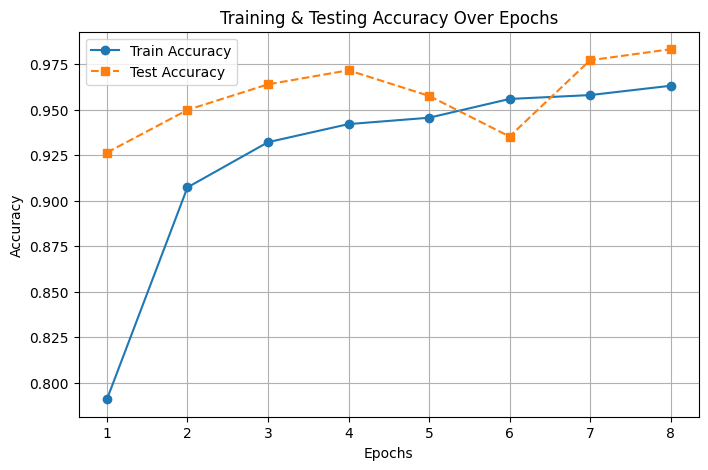

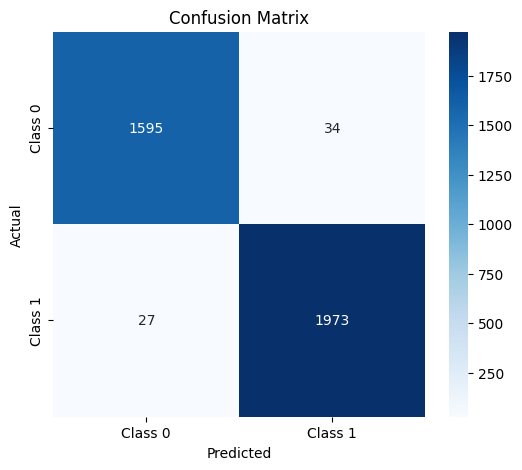

### validating the best model ###

Test Accuracy: 98.32%
Precision: 0.98
Recall: 0.98
F1-Score: 0.98
ROC-AUC Score: 1.00

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.98      0.98      0.98      1629
     Class 1       0.98      0.99      0.98      2000

    accuracy                           0.98      3629
   macro avg       0.98      0.98      0.98      3629
weighted avg       0.98      0.98      0.98      3629

### Uploading the trained model ###


best_cars_vs_planes_model_20250206_190324.pth:   0%|          | 0.00/49.7M [00:00<?, ?B/s]

Model uploaded as fearlixg/cars_vs_planes_model/best_cars_vs_planes_model_20250206_190324.pth


In [35]:
def main():

    # Variables
    EPOCHS = 8
    MODEL_NAME = "cars_vs_planes_model"

    """Runs the full training and evaluation pipeline."""
    print("### Getting Hugging Face authentication ###")
    hf_token = get_huggingface_token()

    repo_id, model_filename = get_repo_id_and_model(hf_token, MODEL_NAME)

    print(repo_id)
    device = setup_device()

    print("### Loading datasets ###")
    planes_dataset, cars_dataset = load_datasets()

    print("### Labeling datasets ###")
    planes_dataset, cars_dataset = label_datasets(planes_dataset, cars_dataset)

    print("### Merging and balancing datasets ###")
    final_dataset = merge_and_balance_datasets(planes_dataset, cars_dataset)

    print("### Applying data transformations ###")
    transform_train, transform_test = get_transforms()

    print("### Creating DataLoaders ###")
    train_loader, test_loader = prepare_datasets(final_dataset, transform_train, transform_test)

    print("### Initializing model ###")
    model = setup_model(device)
    criterion, optimizer, scheduler = setup_training_components(model, train_loader)

    print("### Training the model ###")
    trained_model = train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, device, epochs=EPOCHS)

    print("### validating the best model ###")
    validate_model(trained_model, test_loader, device)

    print("### Uploading the trained model ###")
    upload_new_model_with_timestamp(trained_model, repo_id, model_filename, hf_token)

if __name__ == "__main__":
    main()